Best Schedule:
Machine 1: [2, 7] (Total time: 13h)
Machine 2: [9] (Total time: 5h)
Machine 3: [8, 6, 5] (Total time: 13h)
Machine 4: [11, 3] (Total time: 13h)
Machine 5: [12, 10, 4, 1] (Total time: 11h)
Best Makespan: 13 hours


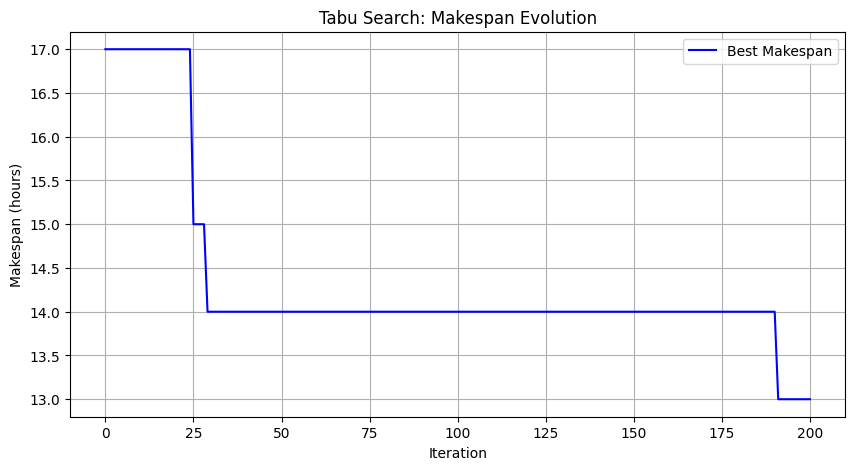

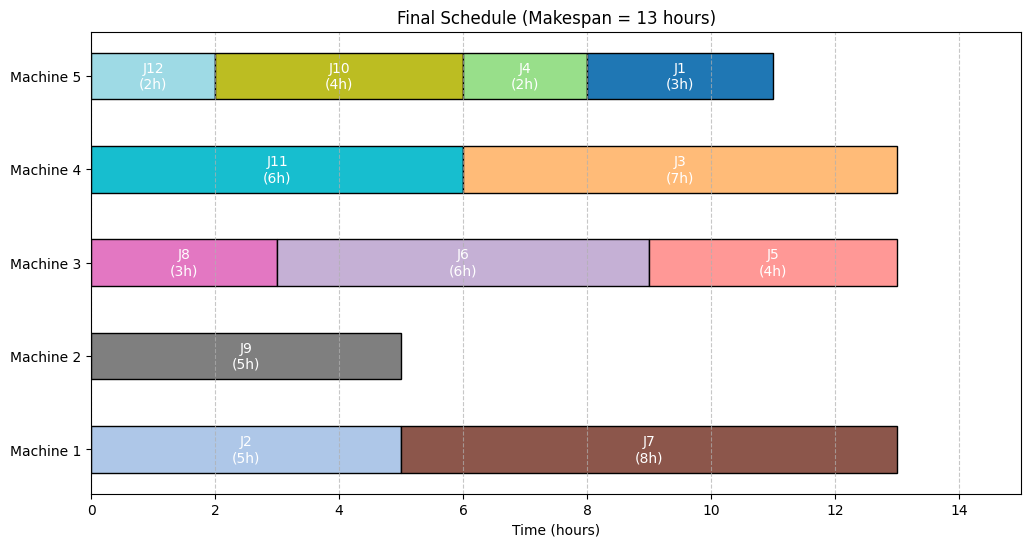

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Job processing times (12 jobs)
jobs = {
    1: 3, 2: 5, 3: 7, 4: 2, 5: 4, 6: 6,
    7: 8, 8: 3, 9: 5, 10: 4, 11: 6, 12: 2
}

# Number of machines
num_machines = 5

# Tabu Search parameters
max_iterations = 200
tabu_tenure = 5  # How long a move stays tabu

def initial_solution(jobs, num_machines):
    """Create a random initial assignment of jobs to machines."""
    schedule = [[] for _ in range(num_machines)]
    job_list = list(jobs.keys())
    random.shuffle(job_list)
    for i, job in enumerate(job_list):
        machine = i % num_machines  # Distribute jobs round-robin
        schedule[machine].append(job)
    return schedule

def calculate_makespan(schedule, jobs):
    """Calculate the makespan (max completion time across machines)."""
    machine_times = [sum(jobs[job] for job in machine) for machine in schedule]
    return max(machine_times)

def get_neighbor(schedule):
    """Generate a neighbor by moving a job from one machine to another."""
    new_schedule = [machine[:] for machine in schedule]  # Deep copy
    # Pick a random job to move
    from_machine = random.choice([i for i, m in enumerate(new_schedule) if m])
    job = random.choice(new_schedule[from_machine])
    # Pick a different machine to move it to
    to_machine = random.choice([i for i in range(num_machines) if i != from_machine])
    # Move the job
    new_schedule[from_machine].remove(job)
    new_schedule[to_machine].append(job)
    return new_schedule, (job, from_machine, to_machine)

def tabu_search(jobs, num_machines, max_iterations, tabu_tenure):
    """Implement Tabu Search to minimize makespan."""
    # Initialize
    current_solution = initial_solution(jobs, num_machines)
    best_solution = current_solution[:]
    best_makespan = calculate_makespan(best_solution, jobs)
    tabu_list = []  # List of (job, from_machine, to_machine) moves
    makespan_history = [best_makespan]

    for iteration in range(max_iterations):
        # Generate a neighbor
        neighbor, move = get_neighbor(current_solution)
        neighbor_makespan = calculate_makespan(neighbor, jobs)

        # Check if move is tabu (reverse move is in tabu list)
        reverse_move = (move[0], move[2], move[1])  # (job, to_machine, from_machine)
        if reverse_move not in tabu_list:
            # Accept the move if it improves or is non-tabu
            if neighbor_makespan < best_makespan:
                best_solution = [m[:] for m in neighbor]
                best_makespan = neighbor_makespan
            current_solution = neighbor
            # Update tabu list
            tabu_list.append(move)
            if len(tabu_list) > tabu_tenure:
                tabu_list.pop(0)  # Remove oldest move
        else:
            # Skip tabu move unless it beats best solution (aspiration criterion)
            if neighbor_makespan < best_makespan:
                best_solution = [m[:] for m in neighbor]
                best_makespan = neighbor_makespan
                current_solution = neighbor
                tabu_list.append(move)
                if len(tabu_list) > tabu_tenure:
                    tabu_list.pop(0)

        makespan_history.append(best_makespan)

    return best_solution, best_makespan, makespan_history

def plot_makespan_history(makespan_history):
    """Plot the makespan over iterations."""
    plt.figure(figsize=(10, 5))
    plt.plot(makespan_history, label='Best Makespan', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('Makespan (hours)')
    plt.title('Tabu Search: Makespan Evolution')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_gantt_chart(schedule, jobs, makespan):
    """Create a Gantt chart for the final schedule."""
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, len(jobs)))  # Unique color per job

    for m_idx, machine in enumerate(schedule):
        start_time = 0
        for job in machine:
            duration = jobs[job]
            ax.barh(m_idx, duration, left=start_time, height=0.5, color=colors[job-1], edgecolor='black')
            ax.text(start_time + duration/2, m_idx, f'J{job}\n({duration}h)',
                    ha='center', va='center', color='white', fontsize=10)
            start_time += duration

    ax.set_yticks(range(num_machines))
    ax.set_yticklabels([f'Machine {i+1}' for i in range(num_machines)])
    ax.set_xlabel('Time (hours)')
    ax.set_title(f'Final Schedule (Makespan = {makespan} hours)')
    ax.set_xlim(0, max(makespan, 15))  # Ensure visibility
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Run Tabu Search
best_solution, best_makespan, makespan_history = tabu_search(jobs, num_machines, max_iterations, tabu_tenure)

# Print results
print("Best Schedule:")
for i, machine in enumerate(best_solution):
    print(f"Machine {i+1}: {machine} (Total time: {sum(jobs[j] for j in machine)}h)")
print(f"Best Makespan: {best_makespan} hours")

# Visualizations
plot_makespan_history(makespan_history)
plot_gantt_chart(best_solution, jobs, best_makespan)